In [49]:
# Imports 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D


In [24]:

# reading the data frame

df = pd.read_csv('Mall_Customers.csv')

In [25]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


There are five variables in the dataset. CustomerID is the unique identifier of each customer in the dataset, and we can drop this variable. It doesn’t provide us with any useful cluster information.

Since gender is a categorial variable, it needs to be encoded and converted into numeric.

All other variables will be scaled to follow a normal distribution before being fed into the model. We will standardize these variables with a mean of 0 and a standard deviation of 1.

In [26]:
col_names = ['Annual Income (k$)', 'Age', 'Spending Score (1-100)']
features = df[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
scaled_features = pd.DataFrame(features, columns = col_names)
scaled_features.head()

,Annual Income (k$),Age,Spending Score (1-100)
0,-1.738999,-1.424569,-0.434801
1,-1.738999,-1.281035,1.195704
2,-1.700830,-1.352802,-1.715913
3,-1.700830,-1.137502,1.040418
4,-1.662660,-0.563369,-0.395980


StandardScaler will transform your data such that its distribution will have a mean value 0 and standard deviation of 1

The variable ‘gender’ is categorical, and we need to transform this into a numeric variable.

In [27]:
gender = df['Gender']
newdf = scaled_features.join(gender)

newdf.head()

,Annual Income (k$),Age,Spending Score (1-100),Gender
0,-1.738999,-1.424569,-0.434801,Male
1,-1.738999,-1.281035,1.195704,Male
2,-1.700830,-1.352802,-1.715913,Female
3,-1.700830,-1.137502,1.040418,Female
4,-1.662660,-0.563369,-0.395980,Female


In [28]:
newdf = pd.get_dummies(newdf, prefix=None, prefix_sep='_', dummy_na=False, columns=None, sparse=False, drop_first=False, dtype=None)
newdf.head()

,Annual Income (k$),Age,Spending Score (1-100),Gender_Female,Gender_Male
0,-1.738999,-1.424569,-0.434801,0,1
1,-1.738999,-1.281035,1.195704,0,1
2,-1.700830,-1.352802,-1.715913,1,0
3,-1.700830,-1.137502,1.040418,1,0
4,-1.662660,-0.563369,-0.395980,1,0


In [29]:
newdf = newdf.drop(['Gender_Male'],axis=1)

newdf.head()

,Annual Income (k$),Age,Spending Score (1-100),Gender_Female
0,-1.738999,-1.424569,-0.434801,0
1,-1.738999,-1.281035,1.195704,0
2,-1.700830,-1.352802,-1.715913,1
3,-1.700830,-1.137502,1.040418,1
4,-1.662660,-0.563369,-0.395980,1


The values for ‘Gender_Male’ can be inferred from ‘Gender_Female,’ (that is, if ‘Gender_Female’ is 0, then ‘Gender_Male’ will be 1 and vice versa) therefore Gender_Male column is reviewed.

The elbow plot will tell us tell us the ideal number of clusters to use when building our model

Text(0, 0.5, 'Inertia')

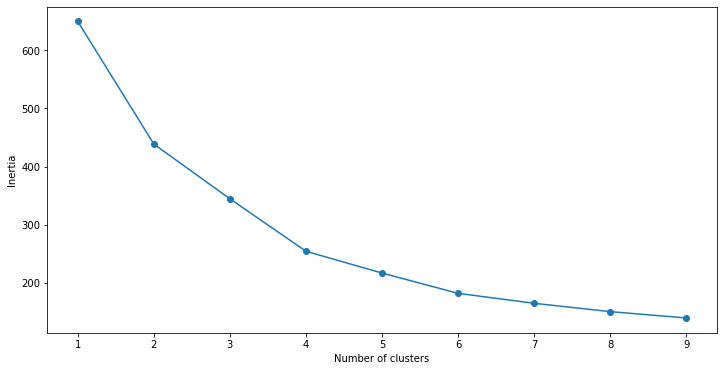

In [34]:
import warnings
warnings.filterwarnings('ignore')

SSE = []

for cluster in range(1,10):
    kmeans = KMeans(n_clusters = cluster, init='k-means++')
    kmeans.fit(newdf)
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them

frame = pd.DataFrame({'Cluster':range(1,10), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

To determine the optimal number of clusters, we have to select the value of k at the “elbow” ie the point after which the distortion/inertia start decreasing in a linear fashion. Thus for the given data, we conclude that the optimal number of clusters for the data is 4.

A silhouette coefficient, or a silhouette score is a metric used to evaluate the quality of clusters created by the algorithm.

Silhouette scores range from -1 to +1. The higher the silhouette score, the better the model.

In [36]:
#  calculate the silhouette score of the model eith 4 clusters

kmeans = KMeans(n_clusters = 4, init='k-means++')
kmeans.fit(newdf)

# Now, print the silhouette score of this model

print(silhouette_score(newdf, kmeans.labels_, metric='euclidean'))

0.35098672687855315


 Before trying get higher cluster separation, visualization of clusters for n = 4 is seen

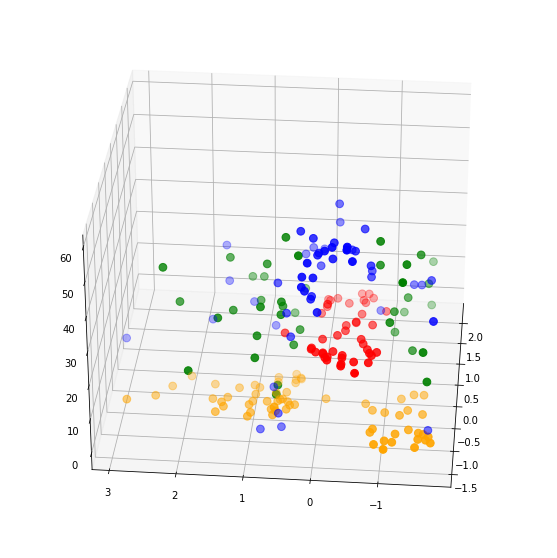

In [40]:
clusters = kmeans.fit_predict(newdf.iloc[:,1:])
newdf["label"] = clusters
 
fig = plt.figure(figsize=(21,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(newdf.Age[newdf.label == 0], newdf["Annual Income (k$)"][newdf.label == 0], df["Spending Score (1-100)"][newdf.label == 0], c='blue', s=60)

ax.scatter(newdf.Age[newdf.label == 1], newdf["Annual Income (k$)"][newdf.label == 1], newdf["Spending Score (1-100)"][newdf.label == 1], c='red', s=60)
ax.scatter(newdf.Age[newdf.label == 2], newdf["Annual Income (k$)"][newdf.label == 2], df["Spending Score (1-100)"][newdf.label == 2], c='green', s=60)
ax.scatter(newdf.Age[newdf.label == 3], newdf["Annual Income (k$)"][newdf.label == 3], newdf["Spending Score (1-100)"][newdf.label == 3], c='orange', s=60)

ax.view_init(30, 185)
plt.show()

From the above diagram, we can see that cluster separation isn’t too great.

The red points are mixed with the blue, and the green are overlapping the yellow.

This, along with the silhouette score shows us that the model isn’t performing too well.

Now, lets create a new model that has better cluster separability than this one.

## Building Second Clustering Model using PCA Dimensionality reduction technique

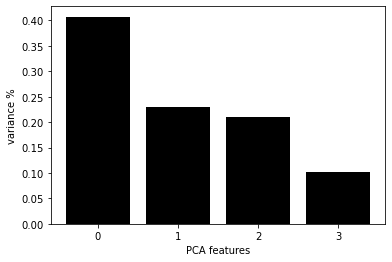

In [41]:
pca = PCA(n_components=4)
principalComponents = pca.fit_transform(newdf)

features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

PCA_components = pd.DataFrame(principalComponents)

we can see that the first two PCA components explain around 70% of the dataset variance.

So we can feed these two components into the KMeans model.

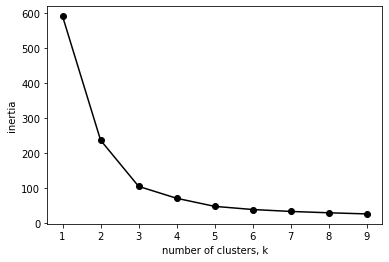

In [42]:
ks = range(1, 10)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(PCA_components.iloc[:,:2])
    inertias.append(model.inertia_)

plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [43]:
model = KMeans(n_clusters=4)
model.fit(PCA_components.iloc[:,:2])

# silhouette score
print(silhouette_score(PCA_components.iloc[:,:2], model.labels_, metric='euclidean'))

0.6025604455573875


We can see again for no. of clusters = 4 the line looks linear but silhouette coefficient score has increased from 0.35 to 0.60. So i visulaized clusters fro this model also.

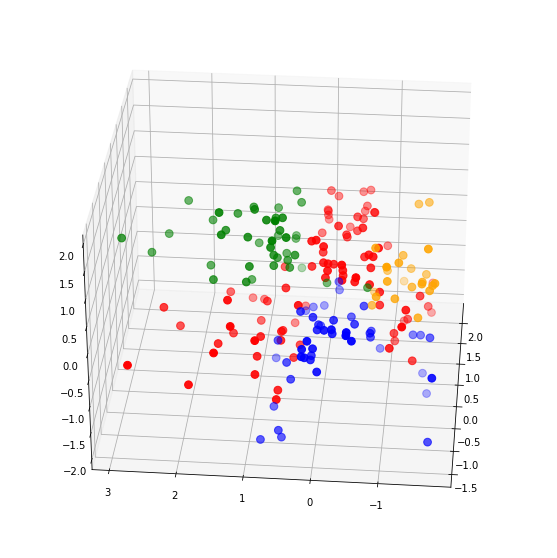

In [44]:
model = KMeans(n_clusters=4)

clusters = model.fit_predict(PCA_components.iloc[:,:2])
newdf["label"] = clusters
 
fig = plt.figure(figsize=(21,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(newdf.Age[newdf.label == 0], newdf["Annual Income (k$)"][newdf.label == 0], newdf["Spending Score (1-100)"][newdf.label == 0], c='blue', s=60)
ax.scatter(newdf.Age[newdf.label == 1], newdf["Annual Income (k$)"][newdf.label == 1], newdf["Spending Score (1-100)"][newdf.label == 1], c='red', s=60)
ax.scatter(newdf.Age[newdf.label == 2], newdf["Annual Income (k$)"][newdf.label == 2], newdf["Spending Score (1-100)"][newdf.label == 2], c='green', s=60)

ax.scatter(newdf.Age[newdf.label == 3], newdf["Annual Income (k$)"][newdf.label == 3], newdf["Spending Score (1-100)"][newdf.label == 3], c='orange', s=60)

ax.view_init(30, 185)
plt.show()

Clusters in the second model are much better separated than that in the first model so i chose second one for continuing the analysis.

In [45]:
df = pd.read_csv('Mall_Customers.csv')
df = df.drop(['CustomerID'],axis=1)

# map back clusters to dataframe

pred = model.predict(PCA_components.iloc[:,:2])
frame = pd.DataFrame(df)
frame['cluster'] = pred
frame.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100),cluster
0,Male,19,15,39,0
1,Male,21,15,81,3
2,Female,20,16,6,0
3,Female,23,16,77,3
4,Female,31,17,40,0


comparision of attributes of the different clusters

In [47]:
avg_df = df.groupby(['cluster'], as_index=False).mean()
avg_df.head()

,cluster,Age,Annual Income (k$),Spending Score (1-100)
0,0,26.659574,53.106383,40.042553
1,1,51.681818,62.125000,33.750000
2,2,32.904762,84.380952,80.500000
3,3,25.521739,26.304348,78.565217


## Spending Score vs Annual Income vs Age

<AxesSubplot:xlabel='cluster', ylabel='Age'>

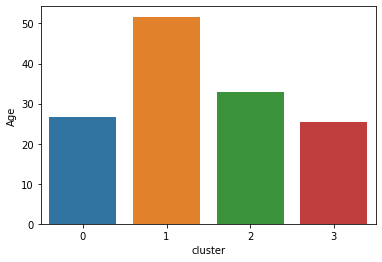

In [52]:
sns.barplot(x='cluster',y='Age',data=avg_df)


<AxesSubplot:xlabel='cluster', ylabel='Spending Score (1-100)'>

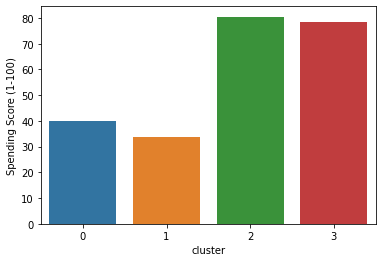

In [53]:
sns.barplot(x='cluster',y='Spending Score (1-100)',data=avg_df)


<AxesSubplot:xlabel='cluster', ylabel='Annual Income (k$)'>

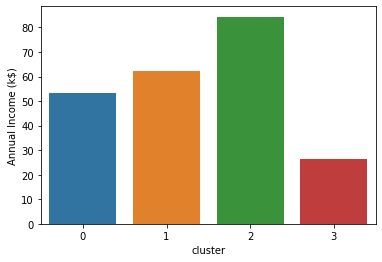

In [54]:
sns.barplot(x='cluster',y='Annual Income (k$)',data=avg_df)

## Gender in different Clusters

In [56]:
df2 = pd.DataFrame(df.groupby(['cluster','Gender'])['Gender'].count())
df2.head()

Gender
cluster Gender        
0       Female      28
        Male        19
1       Female      47
        Male        41
2       Female      23

### We can see that Cluster 0 has higher annual income with low spending and their mean age is 40 and gender is predominantly male therfore Promos, coupons, and discount codes will attract individuals in this segment due to their tendency to spend less

### We can see that Cluster 1 mid average annual income with average spending and their mean age is 50 and gender is predominantly female therefore marketing to these individuals can be done through Facebook, which appeals to an older demographic. Promote healthcare related products to people in this segment

### We can see that Cluster 2 has low average income with high spending and their mean age is 25 and gender is predominantly female therefore young individuals who spend a lot, providing them with travel coupons or hotel discounts might be a good idea. Providing them with discounts off top clothing and makeup brands would also work well for this segment

### We can see that Cluster 3 has high annual income with high spending and their mean age is 30 and gender is predominantly female threfore due to their large spending capacity and their demographic, these individuals are likely to be looking for properties to buy or invest in. They are also more likely than all other segments to take out housing loans and make serious financial commitments.

#### Females are more highly represented in the entire dataset, which is why most clusters contain a larger number of females than males